In [1]:
import ee
import os
import random
import geemap
ee.Authenticate()
ee.Initialize(project = 'tony-1122')
print(ee.String('Hello from the Earth Engine servers!').getInfo())

Hello from the Earth Engine servers!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sample = ee.FeatureCollection('projects/tony-1122/assets/TTU/cotton/cotton_dataset_balance')
sample = ee.data.computeFeatures({
    'expression': sample,
    'fileFormat': 'PANDAS_DATAFRAME'
})

In [4]:
df = sample.iloc[:, 1:-1]
df.head()

,EVI,EVI_p20,EVI_p80,IBI,IBI_p20,IBI_p20_1,ND_blue_green,ND_blue_nir,ND_blue_p20_green_p20,ND_blue_p20_nir_p20,...,red_p80,seasonality,slope,swir1,swir1_p20,swir1_p80,swir2,swir2_p20,swir2_p80,transition
0,0.502492,0.602376,0.687418,0.074117,0.022132,0.022132,-0.041583,-0.261017,-0.046311,-0.224607,...,1.109314,0,2,1.9763,1.398000,1.897380,1.48705,1.090717,1.487333,10
1,0.741118,0.660443,0.676341,-0.008686,0.008613,0.008613,-0.029739,-0.258167,-0.051012,-0.240535,...,1.130400,0,6,1.4843,1.403450,1.904200,1.16550,1.103500,1.505667,10
2,0.514058,0.621734,0.691443,0.072008,0.023714,0.023714,-0.049119,-0.242505,-0.049895,-0.236176,...,1.125150,0,8,1.8066,1.446517,1.892675,1.52975,1.122700,1.494875,10
3,0.754902,0.619685,0.682292,0.016486,0.017687,0.017687,-0.038568,-0.244752,-0.052296,-0.236346,...,1.126650,1,7,1.5525,1.423200,1.903100,1.12830,1.115000,1.505100,5
4,0.462925,0.619685,0.682292,0.083867,0.017687,0.017687,-0.042501,-0.257184,-0.052296,-0.236346,...,1.126650,1,7,2.0097,1.423200,1.903100,1.54375,1.115000,1.505100,5


##**1DCNN**

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Load your dataset
df = sample.iloc[:, 1:-1]  # Replace with actual file path if needed

# Define features (X) and target (y)
feature_cols = [col for col in df.columns if col != 'land_class']
X = df[feature_cols].values  # Convert features to NumPy array
y = df['land_class'].values  # Binary target

# Convert target variable to binary (ensure it's 0 or 1)
y = np.where(y > 0, 1, 0)  # Modify if necessary based on data

# Train-test split (70% training, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data to fit 1D CNN input format (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Define Model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (time_steps, features)

# CNN Layers
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

cnn = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

# Fully Connected Layers
flatten = Flatten()(cnn)
dense1 = Dense(64, activation='relu')(flatten)
dropout = Dropout(0.3)(dense1)
output = Dense(1, activation='sigmoid')(dropout)  # Binary Classification

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('1DCNN_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint], verbose=1)

# Load the best model
model.load_weights('1DCNN_model.h5')

# Predictions
y_pred_prob = model.predict(X_val)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Evaluation Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
mcc = matthews_corrcoef(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print Results
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Epoch 1/50
278/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7131 - loss: 0.6103

282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7136 - loss: 0.6091 - val_accuracy: 0.7700 - val_loss: 0.4876 - learning_rate: 0.0010
Epoch 2/50
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8032 - loss: 0.4329

282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8032 - loss: 0.4329 - val_accuracy: 0.8231 - val_loss: 0.4063 - learning_rate: 0.0010
Epoch 3/50
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8233 - loss: 0.3881

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8233 - loss: 0.3880 - val_accuracy: 0.8267 - val_loss: 0.3779 - learning_rate: 0.0010
Epoch 4/50
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8397 - loss: 0.3596

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8397 - loss: 0.3596 - val_accuracy: 0.8389 - val_loss: 0.3581 - learning_rate: 0.0010
Epoch 5/50
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8669 - loss: 0.3036

282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8668 - loss: 0.3037 - val_accuracy: 0.8415 - val_loss: 0.3751 - learning_rate: 0.0010
Epoch 6/50
279/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8677 - loss: 0.2949

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8676 - loss: 0.2949 - val_accuracy: 0.8575 - val_loss: 0.3289 - learning_rate: 0.0010
Epoch 7/50
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8783 - loss: 0.2729

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8783 - loss: 0.2730 - val_accuracy: 0.8591 - val_loss: 0.3195 - learning_rate: 0.0010
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8761 - loss: 0.2654 - val_accuracy: 0.8563 - val_loss: 0.3335 - learning_rate: 0.0010
Epoch 9/50
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8910 - loss: 0.2489

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8910 - loss: 0.2488 - val_accuracy: 0.8695 - val_loss: 0.3078 - learning_rate: 0.0010
Epoch 10/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8965 - loss: 0.2283 - val_accuracy: 0.8695 - val_loss: 0.3127 - learning_rate: 0.0010
Epoch 11/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9070 - loss: 0.2127 - val_accuracy: 0.8679 - val_loss: 0.2995 - learning_rate: 0.0010
Epoch 12/50
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9092 - loss: 0.2083

282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9091 - loss: 0.2083 - val_accuracy: 0.8752 - val_loss: 0.2983 - learning_rate: 0.0010
Epoch 13/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9167 - loss: 0.1898 - val_accuracy: 0.8746 - val_loss: 0.3084 - learning_rate: 0.0010
Epoch 14/50
279/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9145 - loss: 0.1851

282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9145 - loss: 0.1852 - val_accuracy: 0.8772 - val_loss: 0.3186 - learning_rate: 0.0010
Epoch 15/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9237 - loss: 0.1738 - val_accuracy: 0.8772 - val_loss: 0.2975 - learning_rate: 0.0010
Epoch 16/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9198 - loss: 0.1804 - val_accuracy: 0.8713 - val_loss: 0.3025 - learning_rate: 0.0010
Epoch 17/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9210 - loss: 0.1668 - val_accuracy: 0.8752 - val_loss: 0.3088 - learning_rate: 0.0010
Epoch 18/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9322 - loss: 0.1482 - val_accuracy: 0.8713 - val_loss: 0.3311 - learning_rate: 0.0010
Epoch 19/50
278/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9333 - loss: 0.1421

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9334 - loss: 0.1420 - val_accuracy: 0.8796 - val_loss: 0.3001 - learning_rate: 5.0000e-04
Epoch 20/50
277/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9461 - loss: 0.1154

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9460 - loss: 0.1156 - val_accuracy: 0.8822 - val_loss: 0.3018 - learning_rate: 5.0000e-04
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Evaluation Metrics:
Accuracy: 0.8822
Precision: 0.8892
Recall: 0.9252
F1-score: 0.9069
MCC: 0.7477

Confusion Matrix:
[[1191  276]
 [ 179 2215]]


In [6]:
for layer in model.layers:
    print(layer.name)

input_layer
conv1d
batch_normalization
max_pooling1d
conv1d_1
batch_normalization_1
max_pooling1d_1
flatten
dense
dropout
dense_1


121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


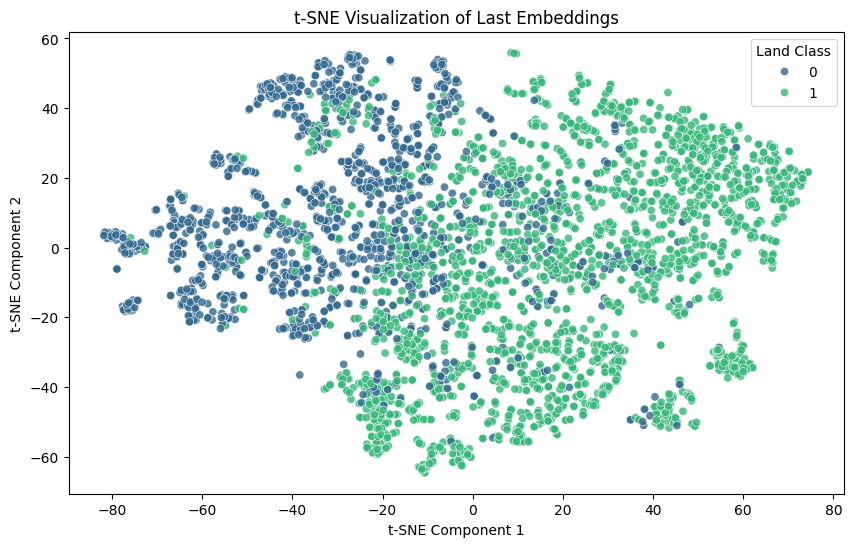

In [8]:
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Extract embeddings from the last Dense layer before the output (correct layer name)
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('dense').output)

# Get embeddings for X_val
X_embeddings = embedding_layer.predict(X_val)

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_embeddings)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_val, palette='viridis', alpha=0.8)
plt.title("t-SNE Visualization of Last Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Land Class")
plt.show()


##**1DCNN + LSTM**

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Load your dataset
df = sample.iloc[:, 1:-1]  # Replace with actual dataset

# Define features (X) and target (y)
feature_cols = [col for col in df.columns if col != 'land_class']
X = df[feature_cols].values  # Convert features to NumPy array
y = df['land_class'].values  # Binary target

# Convert target variable to binary (ensure it's 0 or 1)
y = np.where(y > 0, 1, 0)  # Modify if necessary based on data

# Train-test split (70% training, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data to fit 1D CNN + LSTM input format (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Define Model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (time_steps, features)

# CNN Layers
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

cnn = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

# LSTM Layers
lstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)

# Fully Connected Layers
flatten = Flatten()(lstm)
dense1 = Dense(64, activation='relu')(flatten)
dropout = Dropout(0.3)(dense1)
output = Dense(1, activation='sigmoid')(dropout)  # Binary Classification

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('1DCNNLSTM_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint], verbose=1)

# Load the best model
model.load_weights('1DCNNLSTM_model.h5')

# Predictions
y_pred_prob = model.predict(X_val)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Evaluation Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
mcc = matthews_corrcoef(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print Results
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7112 - loss: 0.5657

282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.7113 - loss: 0.5656 - val_accuracy: 0.7234 - val_loss: 0.5429 - learning_rate: 0.0010
Epoch 2/50
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7941 - loss: 0.4405

282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7942 - loss: 0.4405 - val_accuracy: 0.8226 - val_loss: 0.3909 - learning_rate: 0.0010
Epoch 3/50
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8389 - loss: 0.3635

282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.8389 - loss: 0.3635 - val_accuracy: 0.8482 - val_loss: 0.3446 - learning_rate: 0.0010
Epoch 4/50
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8623 - loss: 0.3150

282/282 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.8623 - loss: 0.3150 - val_accuracy: 0.8500 - val_loss: 0.3363 - learning_rate: 0.0010
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.8783 - loss: 0.2724 - val_accuracy: 0.8495 - val_loss: 0.3239 - learning_rate: 0.0010
Epoch 6/50
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8964 - loss: 0.2380

282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.8964 - loss: 0.2380 - val_accuracy: 0.8669 - val_loss: 0.3261 - learning_rate: 0.0010
Epoch 7/50
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9027 - loss: 0.2096

282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9026 - loss: 0.2096 - val_accuracy: 0.8705 - val_loss: 0.2915 - learning_rate: 0.0010
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9143 - loss: 0.1926 - val_accuracy: 0.8700 - val_loss: 0.3172 - learning_rate: 0.0010
Epoch 9/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.9190 - loss: 0.1738 - val_accuracy: 0.8684 - val_loss: 0.3052 - learning_rate: 0.0010
Epoch 10/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9334 - loss: 0.1458 - val_accuracy: 0.8632 - val_loss: 0.3304 - learning_rate: 0.0010
Epoch 11/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9455 - loss: 0.1235

282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9455 - loss: 0.1235 - val_accuracy: 0.8897 - val_loss: 0.2895 - learning_rate: 5.0000e-04
Epoch 12/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9565 - loss: 0.0967 - val_accuracy: 0.8868 - val_loss: 0.3013 - learning_rate: 5.0000e-04
Epoch 13/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9628 - loss: 0.0878 - val_accuracy: 0.8829 - val_loss: 0.2989 - learning_rate: 5.0000e-04
Epoch 14/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9576 - loss: 0.0881 - val_accuracy: 0.8876 - val_loss: 0.3266 - learning_rate: 5.0000e-04
Epoch 15/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9627 - loss: 0.0795 - val_accuracy: 0.8871 - val_loss: 0.3364 - learning_rate: 2.5000e-04
Epoch 16/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9672 - loss: 0.0710

282/282 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9672 - loss: 0.0710 - val_accuracy: 0.8899 - val_loss: 0.3290 - learning_rate: 2.5000e-04
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Evaluation Metrics:
Accuracy: 0.8899
Precision: 0.9030
Recall: 0.9215
F1-score: 0.9121
MCC: 0.7651

Confusion Matrix:
[[1230  237]
 [ 188 2206]]


In [10]:
for layer in model.layers:
    print(layer.name)

input_layer_1
conv1d_2
batch_normalization_2
max_pooling1d_2
conv1d_3
batch_normalization_3
max_pooling1d_3
bidirectional
flatten_1
dense_2
dropout_1
dense_3


121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


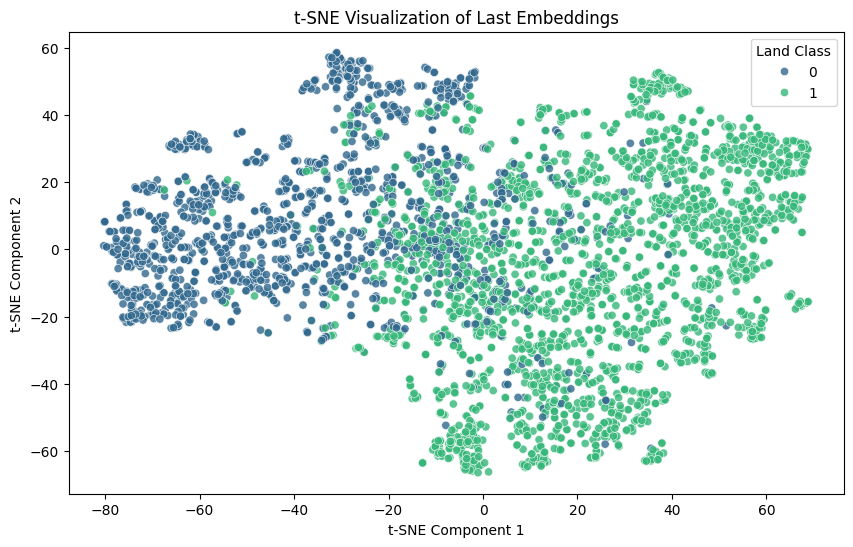

In [11]:
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Extract embeddings from the last Dense layer before the output (correct layer name)
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('dense_2').output)

# Get embeddings for X_val
X_embeddings = embedding_layer.predict(X_val)

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_embeddings)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_val, palette='viridis', alpha=0.8)
plt.title("t-SNE Visualization of Last Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Land Class")
plt.show()


##**1DCNN + LSTM Attention**

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout, Flatten, Bidirectional, Multiply, Permute, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Load and preprocess data
df = sample.iloc[:, 1:-1]  # Adjust column selection as per your dataset

# Define features (X) and target (y)
feature_cols = [col for col in df.columns if col != 'land_class']
X = df[feature_cols].values  # Convert features to NumPy array
y = df['land_class'].values  # Binary target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Check shape before reshaping
num_samples, num_features = X.shape
print(f"Original shape of X: {X.shape}")

# Determine the closest valid time_steps
time_steps = 10  # You may adjust this value based on dataset
n_features = num_features // time_steps  # Ensure it divides evenly

if num_features % time_steps != 0:
    print(f"Warning: num_features ({num_features}) is not divisible by time_steps ({time_steps}). Adjusting...")
    n_features = num_features // time_steps  # Reduce to the closest valid value
    X = X[:, :n_features * time_steps]  # Trim excess columns

# Reshape X to (samples, time_steps, features)
X = X.reshape(-1, time_steps, n_features)
print(f"Reshaped X: {X.shape}")

# Convert y to categorical (for binary classification)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Attention Mechanism
def attention_layer(inputs):
    attention = Dense(inputs.shape[-1], activation='softmax')(inputs)  # Softmax weights
    attention = Multiply()([inputs, attention])  # Apply attention weights
    return attention

# Define Model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (time_steps, features)

# CNN Layers
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

cnn = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

# LSTM Layers
lstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)

# Attention Mechanism
attention = attention_layer(lstm)

# Fully Connected Layers
flatten = Flatten()(attention)
dense1 = Dense(64, activation='relu')(flatten)
dropout = Dropout(0.3)(dense1)
output = Dense(1, activation='sigmoid')(dropout)  # Binary Classification

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('1DCNNLSTM_model_attention.h5', monitor='val_accuracy', save_best_only=True)

# Print Model Summary
model.summary()

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint], verbose=1)

# Load the best model
model.load_weights('1DCNNLSTM_model_attention.h5')

# Evaluate Model
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Results
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Original shape of X: (12870, 83)
Reshaped X: (12870, 10, 8)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 10, 8)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 10, 64)         │          1,600 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 10, 64)         │            256 │ conv1d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 5, 64)          │              0 │ batch_normalization_4… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 5, 32)          │          6,176 │ max_pooling1d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 5, 32)          │            128 │ conv1d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 2, 32)          │              0 │ batch_normalization_5… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 2, 128)         │         49,664 │ max_pooling1d_5[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 2, 128)         │         16,512 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 2, 128)         │              0 │ bidirectional_1[0][0], │
│                           │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 256)            │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │         16,448 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 90,849 (354.88 KB)

 Trainable params: 90,657 (354.13 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
320/322 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6742 - loss: 0.6075

322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6747 - loss: 0.6068 - val_accuracy: 0.7669 - val_loss: 0.4708 - learning_rate: 0.0010
Epoch 2/50
320/322 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8081 - loss: 0.4203

322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8081 - loss: 0.4203 - val_accuracy: 0.8357 - val_loss: 0.3835 - learning_rate: 0.0010
Epoch 3/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8352 - loss: 0.3676

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8352 - loss: 0.3676 - val_accuracy: 0.8430 - val_loss: 0.3567 - learning_rate: 0.0010
Epoch 4/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8524 - loss: 0.3368 - val_accuracy: 0.8294 - val_loss: 0.3804 - learning_rate: 0.0010
Epoch 5/50
321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8722 - loss: 0.2897

322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8722 - loss: 0.2897 - val_accuracy: 0.8582 - val_loss: 0.3219 - learning_rate: 0.0010
Epoch 6/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8753 - loss: 0.2755 - val_accuracy: 0.8559 - val_loss: 0.3277 - learning_rate: 0.0010
Epoch 7/50
321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8953 - loss: 0.2410

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8952 - loss: 0.2410 - val_accuracy: 0.8648 - val_loss: 0.3035 - learning_rate: 0.0010
Epoch 8/50
319/322 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9071 - loss: 0.2186

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9070 - loss: 0.2187 - val_accuracy: 0.8702 - val_loss: 0.3001 - learning_rate: 0.0010
Epoch 9/50
320/322 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9062 - loss: 0.2144

322/322 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9062 - loss: 0.2144 - val_accuracy: 0.8803 - val_loss: 0.2862 - learning_rate: 0.0010
Epoch 10/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9145 - loss: 0.1911 - val_accuracy: 0.8733 - val_loss: 0.3073 - learning_rate: 0.0010
Epoch 11/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9181 - loss: 0.1830 - val_accuracy: 0.8776 - val_loss: 0.2847 - learning_rate: 0.0010
Epoch 12/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9247 - loss: 0.1763 - val_accuracy: 0.8699 - val_loss: 0.3052 - learning_rate: 0.0010
Epoch 13/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9203 - loss: 0.1783 - val_accuracy: 0.8784 - val_loss: 0.3010 - learning_rate: 0.0010
Epoch 14/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9304 - loss: 0.1590 - val_accuracy: 0.8718 - val_loss: 0.3029 - learning_rate: 0.0010
Epoch 15/50
319/322 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9355 - loss: 0.1396

322/322 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9356 - loss: 0.1395 - val_accuracy: 0.8850 - val_loss: 0.3042 - learning_rate: 5.0000e-04
Epoch 16/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9488 - loss: 0.1150 - val_accuracy: 0.8784 - val_loss: 0.3172 - learning_rate: 5.0000e-04
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Evaluation Metrics:
Accuracy: 0.8850
Precision: 0.8988
Recall: 0.9179
F1-score: 0.9082
MCC: 0.7546

Confusion Matrix:
[[ 813  165]
 [ 131 1465]]


In [13]:
for layer in model.layers:
    print(layer.name)

input_layer_2
conv1d_4
batch_normalization_4
max_pooling1d_4
conv1d_5
batch_normalization_5
max_pooling1d_5
bidirectional_1
dense_4
multiply
flatten_2
dense_5
dropout_2
dense_6


✅ Extracts embeddings from the last Dense layer.

✅ Applies t-SNE for dimensionality reduction.

✅ Plots results with colors indicating land classes.

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


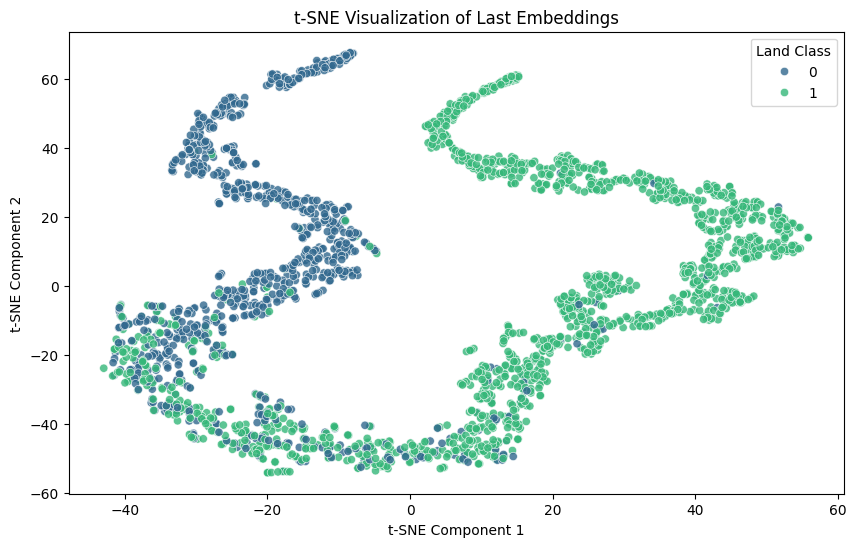

In [14]:
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Extract embeddings from the last Dense layer before the output
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('dense_5').output)  # Using 'dense_27'

# Get embeddings for X_test
X_embeddings = embedding_layer.predict(X_test)

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_embeddings)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_test, palette='viridis', alpha=0.8)
plt.title("t-SNE Visualization of Last Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Land Class")
plt.show()


81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step
Explained Variance: PC1 = 82.87%, PC2 = 16.37%


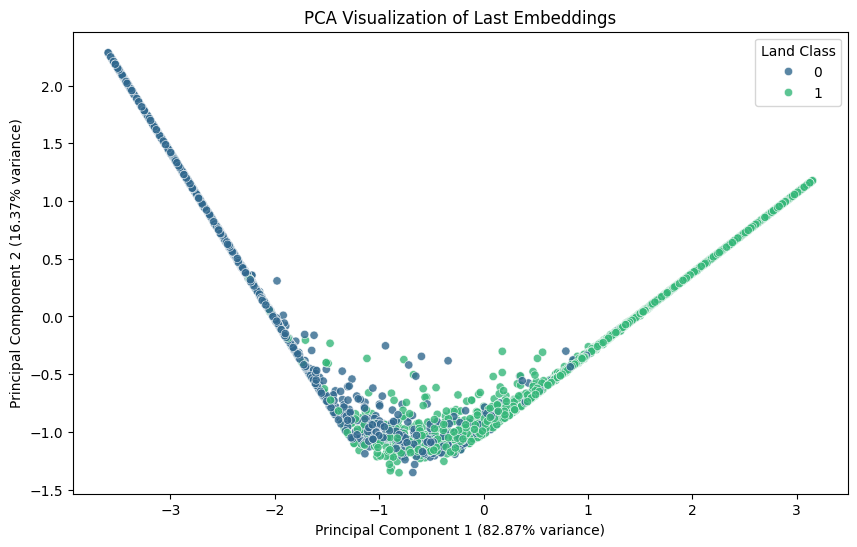

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model

# Extract embeddings from 'dense_27' layer
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('dense_27').output)
X_embeddings = embedding_layer.predict(X_test)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_embeddings)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: PC1 = {explained_variance[0]*100:.2f}%, PC2 = {explained_variance[1]*100:.2f}%")

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test, palette='viridis', alpha=0.8)
plt.title("PCA Visualization of Last Embeddings")
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% variance)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}% variance)")
plt.legend(title="Land Class")
plt.show()
